To check the influence of different data type.

# Using vgg19.mat

In [1]:
import tensorflow as tf
import numpy as np
import scipy.io
from matplotlib import pyplot as plt 
from tqdm import trange

In [2]:
data_path = "../imagenet-vgg-verydeep-19.mat"
data = scipy.io.loadmat(data_path)    
VGG19_LAYERS = (
    'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

    'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

    'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
    'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

    'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
    'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

    'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
    'relu5_3', 'conv5_4', 'relu5_4'
)
weights = data['layers'][0]

In [3]:
def _conv_layer(input, weights, bias):
    # [batch, height, width, channels]
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)
def _pool_layer(input, pooling):
    if pooling == 'avg':
        return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                padding='SAME')
    else:
        # [batch, height, width, channels]
        return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                padding='SAME')

In [4]:
def fun_net(current):
    pooling = 'avg'
    net = {}

    for i, name in enumerate(VGG19_LAYERS):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current, pooling)

        else:
            assert(0)

        net[name] = current
        
    return net["conv2_1"]


# Define loss

In [5]:
x_var = tf.Variable(tf.random_normal( [1,224,224,3] ))

In [6]:
x_var_feature = fun_net( tf.multiply( x_var, 100 ) )

In [7]:
img = scipy.misc.imread( "../monkey.jpg" , mode='RGB').astype(np.float32)
img = scipy.misc.imresize(img, [224, 224])

/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [8]:
img.dtype

dtype('uint8')

In [9]:
img_input_place = tf.placeholder('uint8', shape=[1, 224, 224, 3])

In [10]:
img_input = tf.image.convert_image_dtype(img_input_place, dtype=tf.float32)

In [11]:
img_input = img_input*255

In [12]:
img_feature = fun_net( img_input )

In [13]:
loss = tf.norm(img_feature-x_var_feature, 'euclidean')/tf.norm(img_feature, 'euclidean')

In [14]:
global_step = tf.Variable(0, trainable=False, name='global_step')

In [15]:
# beta1=0.5

In [16]:
train_step = tf.train.AdamOptimizer(learning_rate=0.01, beta1=0.5).minimize(loss, global_step = global_step)

In [17]:
gpu_options = tf.GPUOptions(allow_growth=True)  

In [18]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

# Analysis the influence of data type

In [19]:
fetches = {
    "img_input": img_input,
}

In [20]:
results = sess.run( fetches ,feed_dict={img_input_place:[img]})

In [21]:
loss_list = []

In [22]:
fetches = {
    "train_step": train_step,
    "loss": loss,
}

In [23]:
for _ in trange(2000):
    results = sess.run( fetches ,feed_dict={img_input_place:[img]})
    loss_list.append( results["loss"] )

100%|██████████| 2000/2000 [00:32<00:00, 61.32it/s]


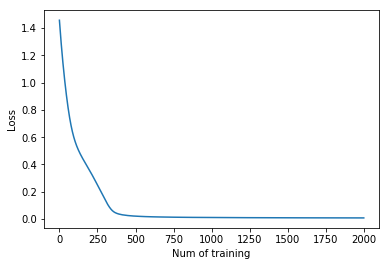

In [24]:
plt.plot( np.array( loss_list ).reshape(-1) ) 
plt.xlabel("Num of training")
plt.ylabel("Loss")
plt.show()

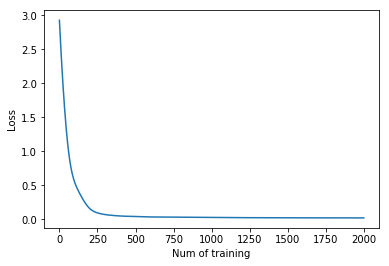

In [29]:
plt.plot( np.array( loss_list ).reshape(-1) ) 
plt.xlabel("Num of training")
plt.ylabel("Loss")
plt.show()

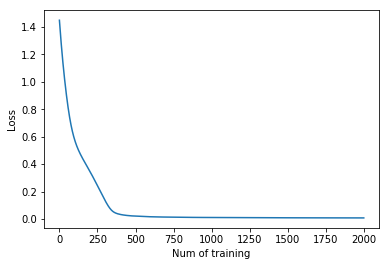

In [24]:
plt.plot( np.array( loss_list ).reshape(-1) ) 
plt.xlabel("Num of training")
plt.ylabel("Loss")
plt.show()

In [25]:
fetches = {
    "x_var": x_var,
}

In [26]:
reaults = sess.run( fetches )

In [27]:
print( np.max(reaults["x_var"]), np.min(reaults["x_var"]) )

(5.6692595, -2.6532571)


In [28]:
print( np.max(reaults["x_var"]), np.min(reaults["x_var"]) )

(6.4287338, -3.081955)


In [28]:
scipy.misc.imsave('ink-out.png', reaults["x_var"][0])


/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


In [35]:
tt = np.ones( [200,200,3] )*0.01

In [37]:
tt[0][0][0] = 0.008

In [38]:
scipy.misc.imsave('ink-out.test.png', tt)


/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


# Image analysis

In [30]:
img2 = scipy.misc.imread( "ink-out.conv2_1.png" , mode='RGB')


/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [38]:
print( np.max(img2), np.min(img2), np.mean(img2), np.std(img2) )

(255, 0, 120.28409332482993, 51.201844821382061)


In [32]:
img1 = scipy.misc.imread( "ink-out.100.0.1.png" , mode='RGB')


/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [39]:
print( np.max(img1), np.min(img1), np.mean(img1), np.std(img1) )

(255, 0, 131.04478236607142, 28.404647980669651)


# Loss of layer analysis

In [19]:
fetches = {
    "loss": loss,
}

In [ ]:
    results = sess.run( fetches ,feed_dict={img_input_place:[img]})
